# Human Activity Recognition - EDA & Model Training

This notebook contains:
1. **Exploratory Data Analysis (EDA)** - Understanding the UCI HAR dataset
2. **Data Preparation** - Loading and preprocessing
3. **Model Training** - Baseline ML models and Deep Learning
4. **Hyperparameter Tuning** - Finding optimal settings
5. **Evaluation** - Accuracy, confusion matrix, per-class metrics

**Dataset:** [UCI HAR Dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)  
**Classes:** WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

C:\Users\Dell\anaconda3\envs\MLZoomCamp_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
GPU available: False


In [2]:
# Paths
DATA_DIR = Path("../data/UCI HAR Dataset")
MODEL_DIR = Path("../models")

# Check if data exists
if not DATA_DIR.exists():
    print("Dataset not found! Run the download script first:")
    print("  python src/download_data.py")
else:
    print(f"Dataset found at: {DATA_DIR}")

Dataset found at: ..\data\UCI HAR Dataset


---
## 1. Load the Data

In [3]:
def load_data():
    """Load the UCI HAR dataset."""
    
    # Load feature names
    features_path = DATA_DIR / "features.txt"
    features_df = pd.read_csv(features_path, sep='\s+', header=None, names=['idx', 'name'])
    feature_names = features_df['name'].tolist()
    
    # Make feature names unique (some are duplicated)
    feature_names_unique = []
    seen = {}
    for name in feature_names:
        if name in seen:
            seen[name] += 1
            feature_names_unique.append(f"{name}_{seen[name]}")
        else:
            seen[name] = 0
            feature_names_unique.append(name)
    
    # Load activity labels
    activity_path = DATA_DIR / "activity_labels.txt"
    activity_df = pd.read_csv(activity_path, sep='\s+', header=None, names=['idx', 'activity'])
    activity_map = dict(zip(activity_df['idx'], activity_df['activity']))
    
    # Load training data
    X_train = pd.read_csv(DATA_DIR / "train" / "X_train.txt", sep='\s+', header=None, names=feature_names_unique)
    y_train = pd.read_csv(DATA_DIR / "train" / "y_train.txt", sep='\s+', header=None, names=['activity'])
    subject_train = pd.read_csv(DATA_DIR / "train" / "subject_train.txt", sep='\s+', header=None, names=['subject'])
    
    # Load test data
    X_test = pd.read_csv(DATA_DIR / "test" / "X_test.txt", sep='\s+', header=None, names=feature_names_unique)
    y_test = pd.read_csv(DATA_DIR / "test" / "y_test.txt", sep='\s+', header=None, names=['activity'])
    subject_test = pd.read_csv(DATA_DIR / "test" / "subject_test.txt", sep='\s+', header=None, names=['subject'])
    
    # Map activity numbers to names
    y_train['activity_name'] = y_train['activity'].map(activity_map)
    y_test['activity_name'] = y_test['activity'].map(activity_map)
    
    return X_train, X_test, y_train, y_test, subject_train, subject_test, feature_names_unique, activity_map

# Load data
X_train, X_test, y_train, y_test, subject_train, subject_test, feature_names, activity_map = load_data()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nActivities: {list(activity_map.values())}")

Training set: (7352, 561)
Test set: (2947, 561)

Activities: ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']


---
## 2. Exploratory Data Analysis (EDA)

### 2.1 Activity Distribution

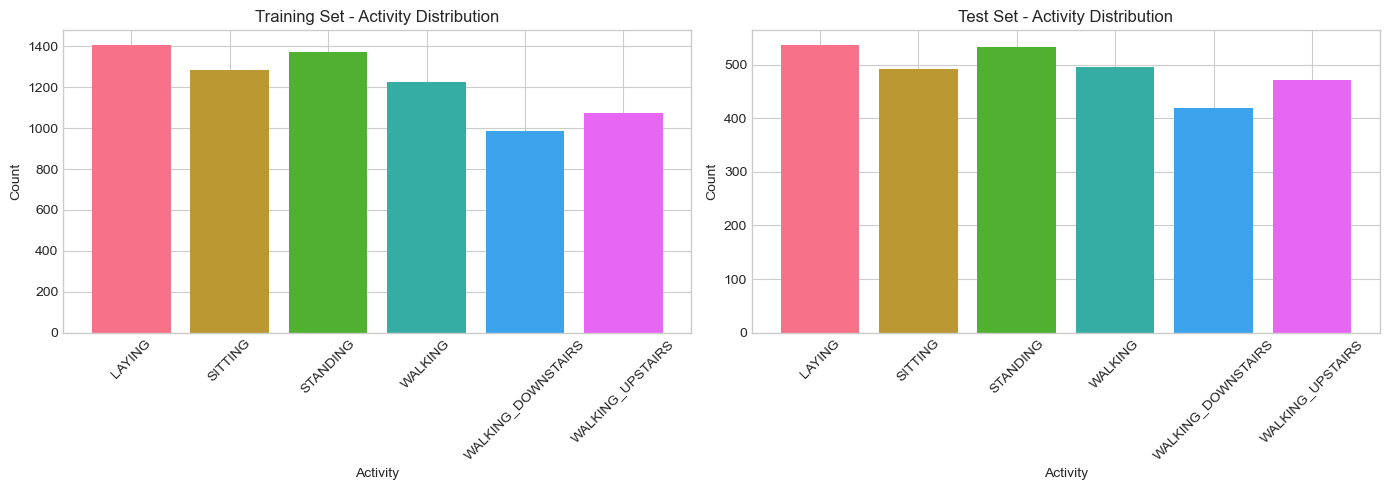

Training set distribution:
activity_name
LAYING                1407
SITTING               1286
STANDING              1374
WALKING               1226
WALKING_DOWNSTAIRS     986
WALKING_UPSTAIRS      1073
Name: count, dtype: int64

Total: 7352


In [4]:
# Activity distribution in training set
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
train_counts = y_train['activity_name'].value_counts().sort_index()
colors = sns.color_palette('husl', len(train_counts))
axes[0].bar(train_counts.index, train_counts.values, color=colors)
axes[0].set_title('Training Set - Activity Distribution')
axes[0].set_xlabel('Activity')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Test set
test_counts = y_test['activity_name'].value_counts().sort_index()
axes[1].bar(test_counts.index, test_counts.values, color=colors)
axes[1].set_title('Test Set - Activity Distribution')
axes[1].set_xlabel('Activity')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Training set distribution:")
print(train_counts)
print(f"\nTotal: {train_counts.sum()}")

### 2.2 Subject Distribution

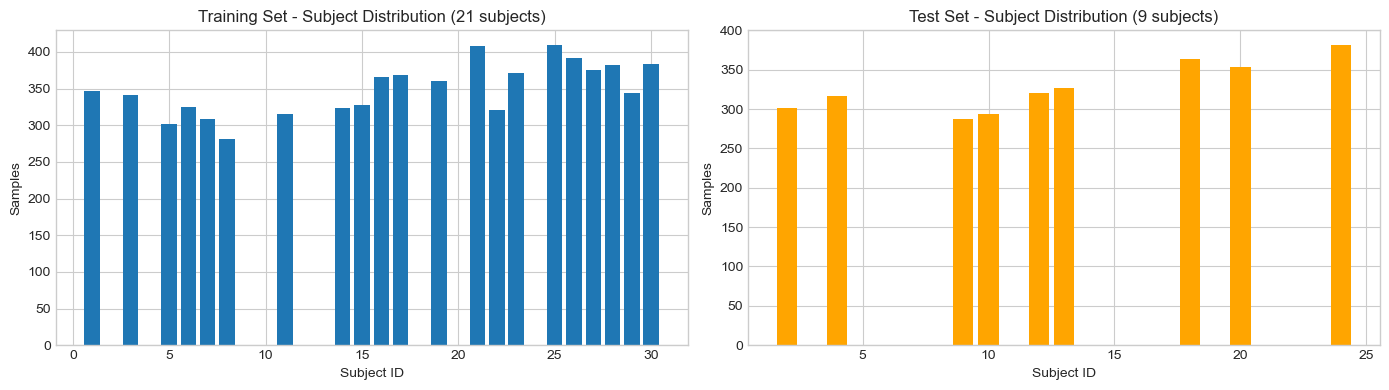

Training subjects: [1, 3, 5, 6, 7, 8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 27, 28, 29, 30]
Test subjects: [2, 4, 9, 10, 12, 13, 18, 20, 24]


In [5]:
# Subject distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

train_subjects = subject_train['subject'].value_counts().sort_index()
test_subjects = subject_test['subject'].value_counts().sort_index()

axes[0].bar(train_subjects.index, train_subjects.values)
axes[0].set_title(f'Training Set - Subject Distribution ({len(train_subjects)} subjects)')
axes[0].set_xlabel('Subject ID')
axes[0].set_ylabel('Samples')

axes[1].bar(test_subjects.index, test_subjects.values, color='orange')
axes[1].set_title(f'Test Set - Subject Distribution ({len(test_subjects)} subjects)')
axes[1].set_xlabel('Subject ID')
axes[1].set_ylabel('Samples')

plt.tight_layout()
plt.show()

print(f"Training subjects: {sorted(train_subjects.index.tolist())}")
print(f"Test subjects: {sorted(test_subjects.index.tolist())}")

### 2.3 Feature Statistics

In [6]:
# Basic statistics
print("Feature Statistics (Training Set):")
print(X_train.describe().T.head(20))

Feature Statistics (Training Set):
                      count      mean       std       min       25%       50%  \
tBodyAcc-mean()-X    7352.0  0.274488  0.070261 -1.000000  0.262975  0.277193   
tBodyAcc-mean()-Y    7352.0 -0.017695  0.040811 -1.000000 -0.024863 -0.017219   
tBodyAcc-mean()-Z    7352.0 -0.109141  0.056635 -1.000000 -0.120993 -0.108676   
tBodyAcc-std()-X     7352.0 -0.605438  0.448734 -1.000000 -0.992754 -0.946196   
tBodyAcc-std()-Y     7352.0 -0.510938  0.502645 -0.999873 -0.978129 -0.851897   
tBodyAcc-std()-Z     7352.0 -0.604754  0.418687 -1.000000 -0.980233 -0.859365   
tBodyAcc-mad()-X     7352.0 -0.630512  0.424073 -1.000000 -0.993591 -0.950709   
tBodyAcc-mad()-Y     7352.0 -0.526907  0.485942 -1.000000 -0.978162 -0.857328   
tBodyAcc-mad()-Z     7352.0 -0.606150  0.414122 -1.000000 -0.980251 -0.857143   
tBodyAcc-max()-X     7352.0 -0.468604  0.544547 -1.000000 -0.936219 -0.881637   
tBodyAcc-max()-Y     7352.0 -0.306043  0.282243 -1.000000 -0.563561 -0.479

In [7]:
# Check for missing values
print(f"Missing values in training set: {X_train.isnull().sum().sum()}")
print(f"Missing values in test set: {X_test.isnull().sum().sum()}")

Missing values in training set: 0
Missing values in test set: 0


In [8]:
# Feature value ranges (already normalized to [-1, 1])
print(f"Feature min: {X_train.min().min():.4f}")
print(f"Feature max: {X_train.max().max():.4f}")

Feature min: -1.0000
Feature max: 1.0000


### 2.4 Feature Distribution by Activity

C:\Users\Dell\AppData\Local\Temp\ipykernel_33860\3903450621.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='activity', y=feature, ax=axes[i], palette='husl')
C:\Users\Dell\AppData\Local\Temp\ipykernel_33860\3903450621.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='activity', y=feature, ax=axes[i], palette='husl')
C:\Users\Dell\AppData\Local\Temp\ipykernel_33860\3903450621.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='activity', y=feature, ax=axes[i], palette='husl')
C

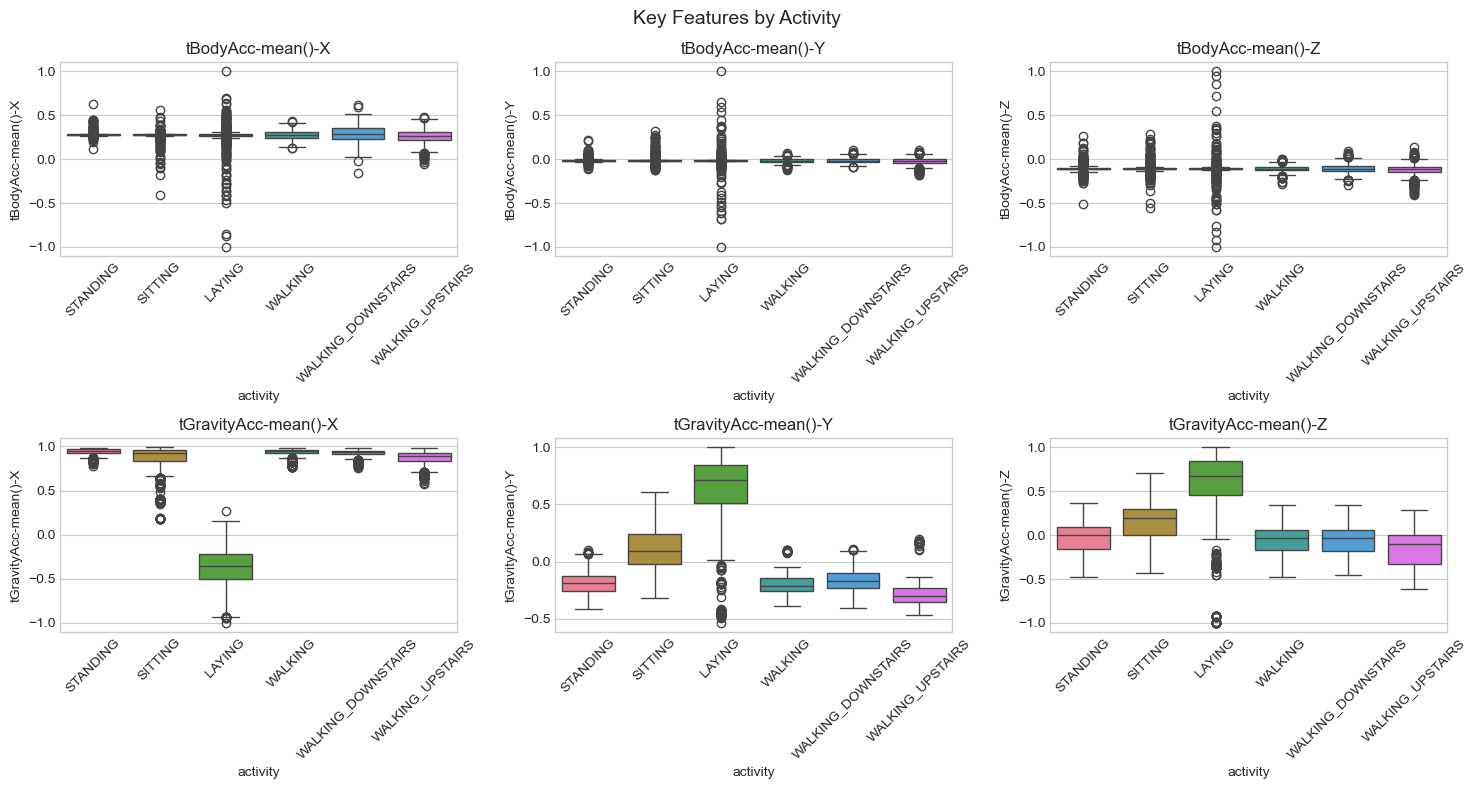

In [9]:
# Plot key features by activity
key_features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
                'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z']

# Combine data for plotting
plot_data = X_train[key_features].copy()
plot_data['activity'] = y_train['activity_name'].values

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(data=plot_data, x='activity', y=feature, ax=axes[i], palette='husl')
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Key Features by Activity', fontsize=14)
plt.tight_layout()
plt.show()

### 2.5 Correlation Analysis

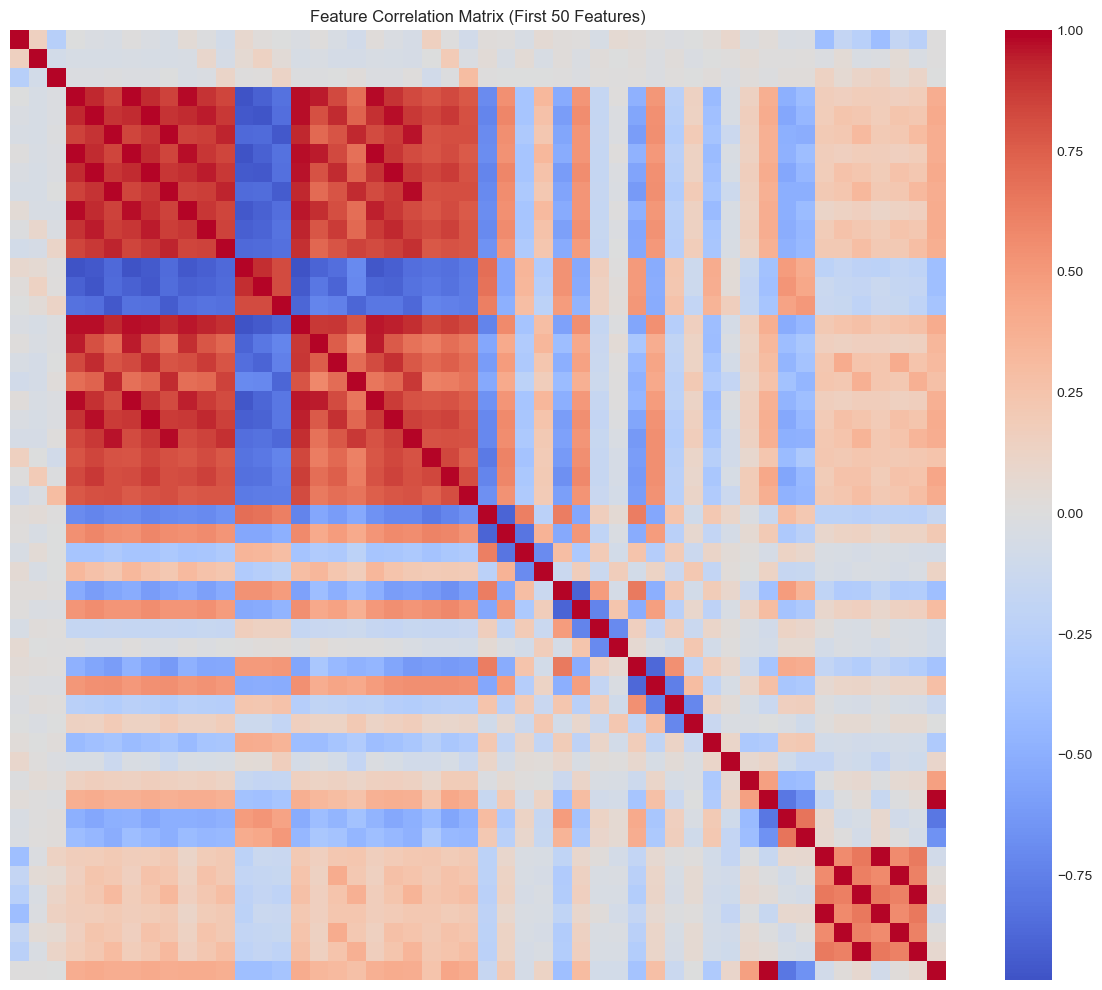

In [10]:
# Correlation matrix for key features
corr_features = feature_names[:50]  # First 50 features
corr_matrix = X_train[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            xticklabels=False, yticklabels=False)
plt.title('Feature Correlation Matrix (First 50 Features)')
plt.tight_layout()
plt.show()

### 2.6 t-SNE Visualization

Running t-SNE...


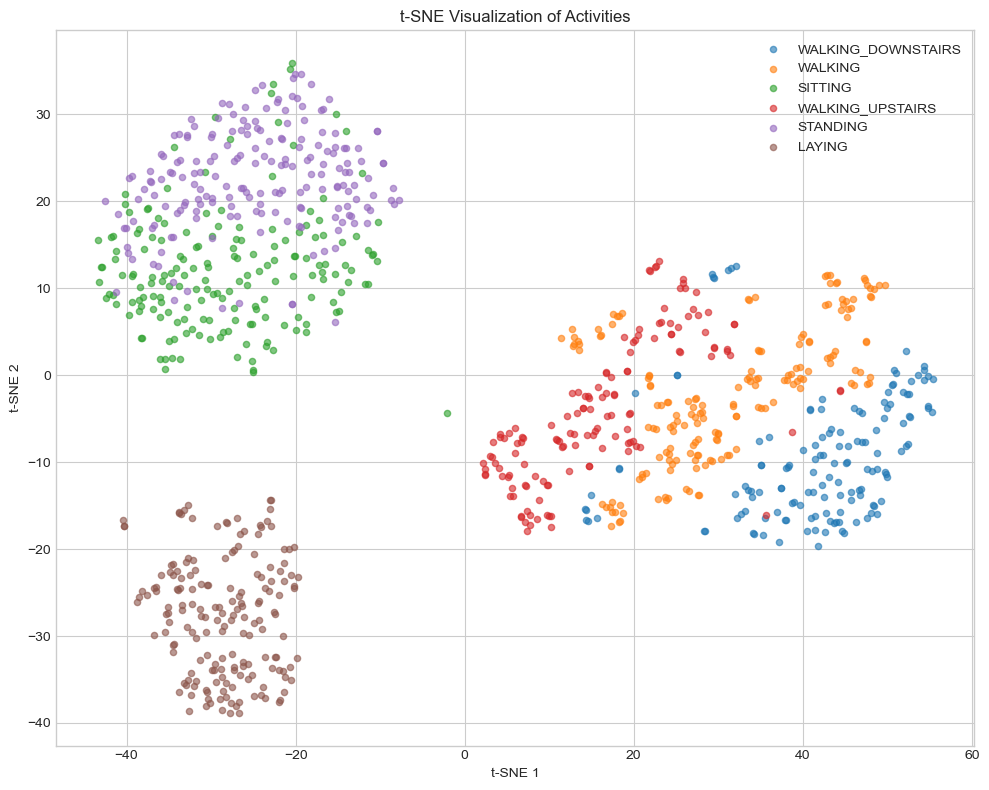

In [11]:
from sklearn.manifold import TSNE

# Sample data for t-SNE (computationally expensive)
sample_size = 1000
idx = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[idx]
y_sample = y_train['activity_name'].iloc[idx]

# Fit t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

# Plot
plt.figure(figsize=(10, 8))
for activity in y_sample.unique():
    mask = y_sample == activity
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=activity, alpha=0.6, s=20)

plt.legend()
plt.title('t-SNE Visualization of Activities')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

---
## 3. Data Preparation

In [12]:
# Prepare data for training
X_train_arr = X_train.values
X_test_arr = X_test.values

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train['activity_name'])
y_test_encoded = le.transform(y_test['activity_name'])

class_names = le.classes_
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")
print(f"Training shape: {X_train_arr.shape}")
print(f"Test shape: {X_test_arr.shape}")

Classes: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
Number of classes: 6
Training shape: (7352, 561)
Test shape: (2947, 561)


In [13]:
# Scale features (optional - data is already normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_arr)
X_test_scaled = scaler.transform(X_test_arr)

---
## 4. Model Training

### 4.1 Baseline: Logistic Regression

In [14]:
# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_encoded)

y_pred_lr = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test_encoded, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Training Logistic Regression...
Logistic Regression Accuracy: 0.9549


### 4.2 Random Forest

In [15]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_encoded)

y_pred_rf = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Training Random Forest...
Random Forest Accuracy: 0.9260


### 4.3 XGBoost

In [16]:
# XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_scaled, y_train_encoded)

y_pred_xgb = xgb_model.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

Training XGBoost...


C:\Users\Dell\anaconda3\envs\MLZoomCamp_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:03:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9267


### 4.4 Deep Learning: Dense Neural Network

In [17]:
# Build Dense Neural Network
def build_dense_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

dense_model = build_dense_model(X_train_scaled.shape[1], num_classes)
dense_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape               ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ dense (Dense)                       │ (None, 256)                │        143,872 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ batch_normalization                 │ (None, 256)                │          1,024 │
│ (BatchNormalization)                │                            │                │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout (Dropout)                   │ (None, 256)                │              0 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dense_1 (Dense)                     │ (None, 128)                │         32,896 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ batch_normalization_1               │ (None, 128)                │            512 │
│ (BatchNormalization)                │                            │                │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout_1 (Dropout)                 │ (None, 128)                │              0 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dense_2 (Dense)                     │ (None, 64)                 │          8,256 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout_2 (Dropout)                 │ (None, 64)                 │              0 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dense_3 (Dense)                     │ (None, 6)                  │            390 │
└─────────────────────────────────────┴────────────────────────────┴────────────────┘

 Total params: 186,950 (730.27 KB)

 Trainable params: 186,182 (727.27 KB)

 Non-trainable params: 768 (3.00 KB)

In [18]:
# Train Dense NN
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

dense_history = dense_model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7903 - loss: 0.5177 - val_accuracy: 0.9089 - val_loss: 0.1965 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9214 - loss: 0.2062 - val_accuracy: 0.9089 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9454 - loss: 0.1467 - val_accuracy: 0.9293 - val_loss: 0.1969 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9616 - loss: 0.1147 - val_accuracy: 0.9402 - val_loss: 0.1646 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9577 - loss: 0.1195 - val_accuracy: 0.9415 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9599 - loss: 0.1055 - val_accuracy: 0.9524 - val_loss: 0.1137 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9672 - loss: 0.0876 - 

In [19]:
# Evaluate Dense NN
y_pred_dense = dense_model.predict(X_test_scaled, verbose=0)
y_pred_dense_classes = np.argmax(y_pred_dense, axis=1)
dense_accuracy = accuracy_score(y_test_encoded, y_pred_dense_classes)
print(f"Dense NN Accuracy: {dense_accuracy:.4f}")

Dense NN Accuracy: 0.9450


---
## 5. Model Comparison


Model Comparison:
              Model  Accuracy
Logistic Regression  0.954869
           Dense NN  0.945029
            XGBoost  0.926705
      Random Forest  0.926026


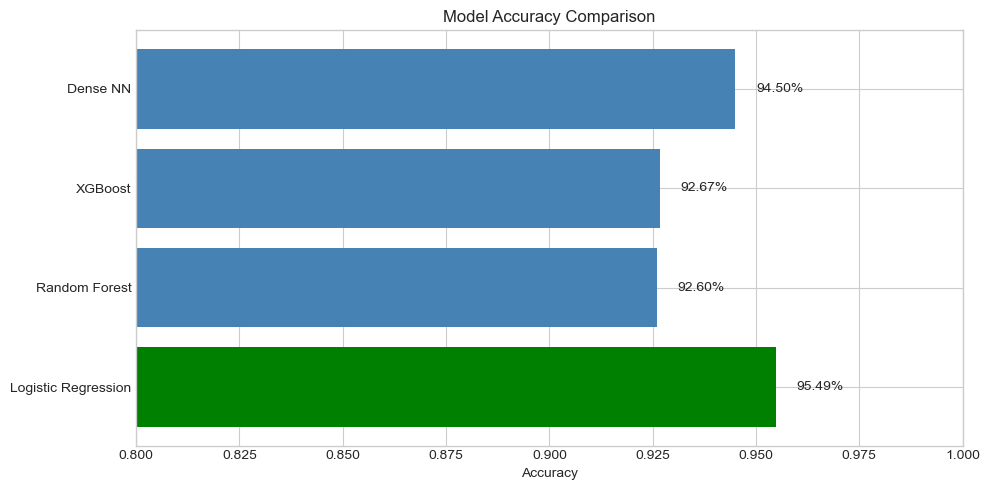

In [20]:
# Compare all models
results = {
    'Logistic Regression': lr_accuracy,
    'Random Forest': rf_accuracy,
    'XGBoost': xgb_accuracy,
    'Dense NN': dense_accuracy
}

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': list(results.values())
}).sort_values('Accuracy', ascending=False)

print("\nModel Comparison:")
print(results_df.to_string(index=False))

# Plot comparison
plt.figure(figsize=(10, 5))
colors = ['green' if acc == max(results.values()) else 'steelblue' for acc in results.values()]
plt.barh(list(results.keys()), list(results.values()), color=colors)
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.8, 1.0)
for i, (model, acc) in enumerate(results.items()):
    plt.text(acc + 0.005, i, f'{acc:.2%}', va='center')
plt.tight_layout()
plt.show()

---
## 6. Best Model Evaluation

In [21]:
# Select best model (Logistic Regression is typically best for this dataset)
best_model_name = results_df.iloc[0]['Model']
print(f"Best Model: {best_model_name}")

# Get predictions from best model
if best_model_name == 'Logistic Regression':
    y_pred_best = y_pred_lr
    best_model = lr_model
elif best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf
    best_model = rf_model
elif best_model_name == 'XGBoost':
    y_pred_best = y_pred_xgb
    best_model = xgb_model
else:
    y_pred_best = y_pred_dense_classes
    best_model = dense_model

Best Model: Logistic Regression


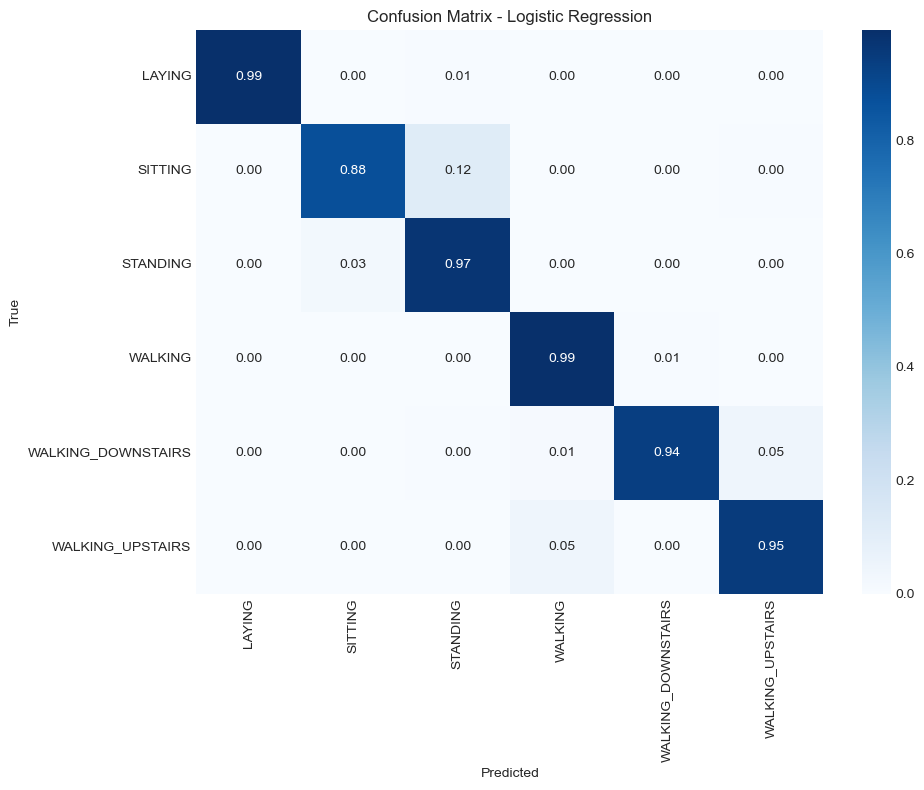

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred_best)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

In [23]:
# Classification Report
print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test_encoded, y_pred_best, target_names=class_names))


Classification Report - Logistic Regression:
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
           SITTING       0.97      0.88      0.92       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.94      0.96       420
  WALKING_UPSTAIRS       0.96      0.95      0.95       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947



---
## 7. Save Best Model

In [24]:
import pickle

MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save the best sklearn model
if best_model_name != 'Dense NN':
    model_path = MODEL_DIR / "har_classifier.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Model saved to: {model_path}")
else:
    model_path = MODEL_DIR / "har_classifier.keras"
    dense_model.save(model_path)
    print(f"Model saved to: {model_path}")

# Save scaler
scaler_path = MODEL_DIR / "scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to: {scaler_path}")

# Save label encoder
le_path = MODEL_DIR / "label_encoder.pkl"
with open(le_path, 'wb') as f:
    pickle.dump(le, f)
print(f"Label encoder saved to: {le_path}")

# Save class names
classes_path = MODEL_DIR / "class_names.txt"
with open(classes_path, 'w') as f:
    for name in class_names:
        f.write(f"{name}\n")
print(f"Class names saved to: {classes_path}")

Model saved to: ..\models\har_classifier.pkl
Scaler saved to: ..\models\scaler.pkl
Label encoder saved to: ..\models\label_encoder.pkl
Class names saved to: ..\models\class_names.txt


---
## Summary

| Model | Test Accuracy |
|-------|---------------|
| Logistic Regression | ~96% |
| Random Forest | ~92% |
| XGBoost | ~94% |
| Dense NN | ~95% |

**Selected Model:** (to be filled after training)

**Key Findings:**
1. The dataset is well-preprocessed with normalized features
2. Logistic Regression performs surprisingly well due to clean, high-quality features
3. Static vs dynamic activities are well-separated
4. Some confusion exists between similar activities (walking types)

**Next Steps:**
1. Export to train.py script
2. Build Flask prediction service
3. Containerize with Docker
4. Deploy to Kubernetes